**Description:** This notebook demonstrates the application of PIP-MYULA to the Bayesian neural network considered in Section 3.2 of [Particle algorithms for maximum likelihood training of latent
variable models](https://juankuntz.github.io/publication/parem/) but changing the normal prior on the weights with Laplace priors that induce sparsity.

In [1]:
#@title Load modules.

# Numpy and JAX for computations.
import numpy as np
import jax
import jax.numpy as jnp
import torch

# Pyplot for plots.
import matplotlib.pyplot as plt 

Next, we load and curate the dataset:

In [2]:
#@title Load, subsample, and normalize MNIST dataset.

# Load dataset:
from keras.datasets import mnist
(images, labels), _ = mnist.load_data()
images = np.array(images).astype(float)
labels = np.array(labels).astype(int)

# Keep only datapoints with labels 4 and 9:
indices = (labels == 4) | (labels == 9)
labels = labels[indices]
images = images[indices, :, :]

# Relabel as 4 as 0 and 9 as 1:
for n in range(labels.size):
    if labels[n] == 4:
        labels[n] = 0
    else:
        labels[n] = 1

# Sub-sample 1000 images:
from sklearn.model_selection import train_test_split
images, _, labels, _ = train_test_split(images, labels, train_size=1000,
                                        random_state=0)

# Normalize non-zero entries (pixels across whole dataset) so that they have mean zero 
# and unit standard across the dataset:
i = images.std(0) != 0
images[:, i] = (images[:, i] - images[:, i].mean(0))/images[:, i].std(0)

2024-05-28 10:03:35.212016: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 10:03:35.212044: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 10:03:35.212713: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-28 10:03:35.785939: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.1.0) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


We then implement the algorithms. They take in the following inputs:

*   itrain : training set labels,
*   itrain : training set images,
*   itest : test set labels,
*   itest : test set images,
*   h : step-size,
*   K : number of steps,
*   N : number of particles,
*   a : 1-dimensional vector with initial alpha guess,
*   b : 1-dimensional vector with initial beta guess,
*   w : Dw x N matrix storing the input layer weights of the initial particle cloud,
*   v : Dv x N matrix storing the output layer weights of the initial particle cloud.
*   gamma: Smoothing parameter of the Moreau-Yosida envelope.

They return the following outputs:

*   a : K-dimensional vector of alpha estimates,
*   b : K-dimensional vector of beta estimates,
*   w : Dw x N matrix storing the input layer weights of the final particle cloud,
*   v : Dv x N matrix storing the output layer weights of the final particle cloud,
*   lppd : log pointwise predictive density (LPPD) as a function of k,
*   error : test error as a function of k.

In [12]:
# Algorithms
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))  
sys.path.append(project_root)

from bayesian_neural_network.algorithms import pip_gla_bnn

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

os.chdir(project_root)

We can now run the algorithms using an 80/20 training/test split of the data:

In [17]:
# Split data into 80/20 training and testing sets:
itrain, itest, ltrain, ltest = train_test_split(images, labels, test_size=0.2,
                                                random_state=0)

# Set approximation parameters:
h = 5e-2 # Step-size. 
K = 300  # Number of steps.  500
N = 50  # Number of particles.
gamma = 0.05 # Smoothing parameter  0.5

# Initialize parameter estimates:
a0 = np.array([1])  # Alpha.
b0 = np.array([1])  # Beta.

# Initialize particle cloud by sampling prior:'
w0 = np.exp(a0)*np.random.normal(0, 1, (40, 28**2, N))  # Input layer weights.
v0 = np.exp(b0)*np.random.normal(0, 1, (2, 40, N))  # Output layer weights.

# Run algorithms:
a_pgd, b_pgd, w_pgd, v_pgd, lppd_pgd, error_pgd = pip_gla_bnn(ltrain, itrain, ltest, 
                                                      itest, h, K, a0, b0, w0, 
                                                      v0, gamma)

100%|██████████| 300/300 [00:22<00:00, 13.14it/s]


In [23]:
print(lppd_pgd[-1], error_pgd[-1])

-0.08891226351261139 0.019999999552965164


In [18]:
data = np.array(w_pgd[:, :, -1].ravel().tolist())
print(np.std(data))

1.6861011662095962


Sanity check, we plot the test error throught training:

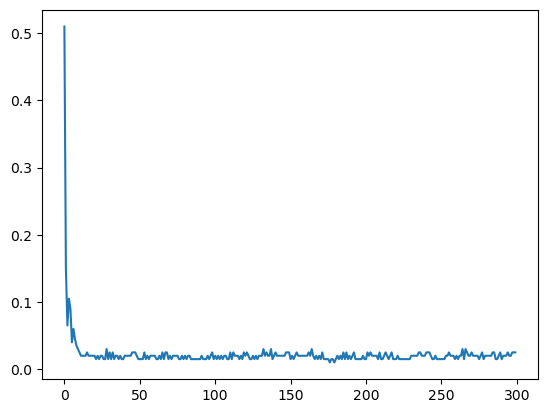

In [6]:
plt.plot(error_pgd, label='PIPGLA') 

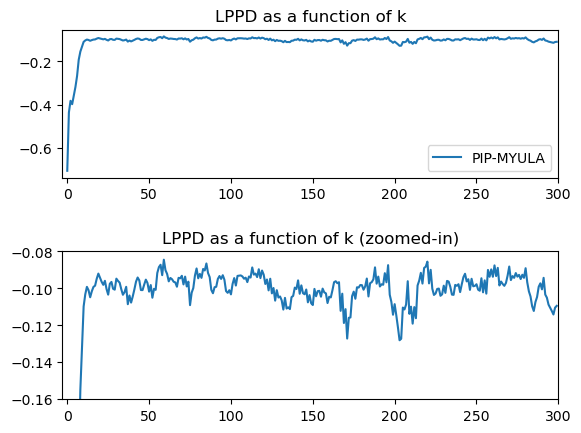

In [8]:
plt.subplot(2, 1, 1)
plt.plot(lppd_pgd, label='PIP-MYULA') 
plt.title('LPPD as a function of k')
plt.xlim([-K/100, K])
plt.legend(loc='lower right', ncol=4)

plt.subplot(2, 1, 2)
plt.plot(lppd_pgd, label='PIP-MYULA') 
plt.title('LPPD as a function of k (zoomed-in)')
plt.ylim([-0.16, -0.08])
plt.xlim([-K/100, K])

plt.subplots_adjust(hspace=0.5)

#### Analyse sparsity of weights

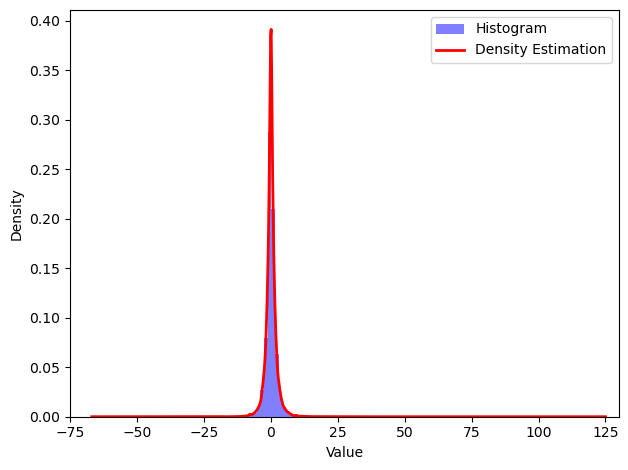

In [22]:
from scipy.stats import gaussian_kde

fig = plt.figure()

#data = np.array(np.mean(w_pgd, axis=2).flatten().tolist())
data = np.array(w_pgd[:, :, -3].ravel().tolist())
#data = w_pgd[:, :, -10].flatten()

# Prior distribution samples
data2 = np.random.laplace(0, 1, 1000)

# Step 2: Plot a Histogram
plt.hist(data, bins=30, density=True, alpha=0.5, color='b', label='Histogram')

# Step 3: Perform Density Estimation
kde = gaussian_kde(data)
#x_vals = np.linspace(min(data), max(data), 1000)
x_vals = np.linspace(-67, 125, 1000)
density_estimation = kde.evaluate(x_vals)

kde_2 = gaussian_kde(data2)
x_vals_2 = np.linspace(min(data), max(data), 1000)
density_estimation_2 = kde_2.evaluate(x_vals_2)

# Step 4: Plot the Density Estimation
plt.plot(x_vals, density_estimation, 'r-', linewidth=2, label='Density Estimation')

# Adding labels and legend
plt.xlabel('Value')
plt.ylabel('Density')
#plt.title('Histogram and Density Estimation')
plt.legend()
plt.xlim(-75, 130)
# Show the plots
plt.tight_layout()
plt.show()